## Setup

In [1]:
# give colab permission to access drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# required for odeformer, although it's annoying to run these so i made the required changes in odeformer
%pip install torch==2.0.0
%pip install numpy==1.23.5

# changed arg weights_only = False in torch.load in sklearn_wrapper to fix a loading error from running dstr = odeformer.model.SymbolicTransformerRegressor, i.e.
# model = torch.load(model_path, weights_only=False)

# also changed np.infty to np.inf

In [2]:
# replace with your drive paths to MIVLE repo, odeformer repo, and shared probing_data folder
repo_path = '/content/drive/MyDrive/aisc/repos/MIVLDE/subteams/LLMProbing'
odeformer_path = '/content/drive/MyDrive/aisc/repos/odeformer'


In [3]:
import sys
import importlib
sys.path.append(repo_path)
sys.path.append(odeformer_path)
import numpy as np
import os
import pickle

In [4]:
samples_path = '/content/drive/MyDrive/aisc/probing_data/samples/derivatives/sigmoid2'
activations_path = '/content/drive/MyDrive/aisc/probing_data/activations/derivatives/sigmoid2'
probes_path = '/content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2'

# # for nt_min=60, nt_max=80
# samples_path = '/content/drive/MyDrive/aisc/probing_data/samples/derivatives/sigmoid'
# activations_path = '/content/drive/MyDrive/aisc/probing_data/activations/derivatives/sigmoid'
# probes_path = '/content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid'

## Generate samples

In [ ]:
from src.sample_generation import ManualSamplesGenerator
msg = ManualSamplesGenerator(samples_path=samples_path)

In [ ]:
# x = a / (1+exp(b*(t0-t)))
# Times array
nt_min = 50
nt_max = 400

# sigmoid parameters
a_values = np.linspace(0,32,33)
# only keeping b in 0<b<1 because the odeformer r2 score for b>1 is low, i.e. < 0.5, and for b>1.5 the r2 score is -1. Looking at plots, odeformer gets the left part of the sigmoid curve correct doesn't increase enough at the inflection point, rather stays flat
# have tried varying the number of timepts, beam size, beam temp and none seemed to help much
b_values = np.linspace(0,1,26)
b_values = b_values[1:]
a_values  = a_values[1:]
t0 = 5.5 # max derivative occurring at t=5.5 for all samples


In [ ]:
# Generate sigmoid samples
msg.generate_sigmoid_samples(a_values, b_values, t0, nt_min, nt_max)

Generating sigmoid samples:   0%|          | 0/800 [00:00<?, ?it/s]

Saving generated samples: 800it [00:05, 137.51it/s]


[INFO] Data generation complete. Saved 800 sigmoid samples to /content/drive/MyDrive/aisc/probing_data/samples/derivatives/sigmoid2


In [ ]:
# Inspect a sigmoid sample to see its keys and some data
samples_dir = os.fsencode(samples_path)
for sample_file in os.listdir(samples_dir):
  sample_name = os.fsdecode(sample_file)
  if "sig" in sample_name:
    sample_path = os.path.join(samples_path, sample_name)
    with open(sample_path, 'rb') as f:
        sample = pickle.load(f)
    print(sample.keys())
    print(sample['expression'])
    print(sample['feature_dict'])
    break

dict_keys(['times', 'trajectory', 'parameters', 'feature_dict', 'expression'])
1.0 / (1+exp(0.04*(5.5-t)))
{'exponential': 0, 'hyperbolic': 0, 'sigmoid': 1, 'derivative_max': 0.01}


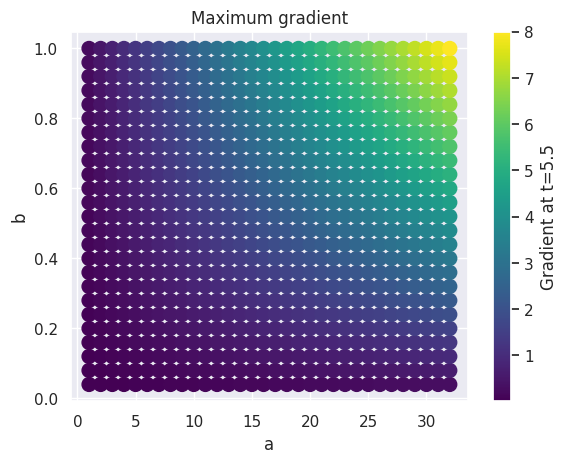

In [ ]:
# plot of derivative at t=5.5, i.e. derivative_max
# not used for anything

import matplotlib.pyplot as plt

# Create grid
A, B = np.meshgrid(a_values, b_values)

# Multiply to get grid results
Z =  A * B /4

# Flatten for scatter plot
x = A.flatten()
y = B.flatten()
z = Z.flatten()

# Scatter plot (color coded by product)
plt.scatter(x, y, c=z, cmap='viridis', s=100)
plt.colorbar(label='Gradient at t=5.5')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Maximum gradient')
plt.grid(True)
plt.show()

## Activation extraction

In [ ]:
%rm odeformer.pt
import odeformer.model
dstr = odeformer.model.SymbolicTransformerRegressor(from_pretrained=True)
model_args = {'beam_size': 10, 'beam_temperature': 0.8} # higher beam temp seems to be better for avoiding nans in solutions. changed from 0.8 temp
dstr.set_model_args(model_args)

rm: cannot remove 'odeformer.pt': No such file or directory


Downloading...
From (original): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W
From (redirected): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W&confirm=t&uuid=0cf17f85-d619-40ec-aef4-a0cbedd78583
To: /content/odeformer.pt
100%|██████████| 465M/465M [00:08<00:00, 51.7MB/s]


Loaded pretrained model


In [ ]:
from src.activation_extraction import ActivationsExtractor

In [ ]:
act_extractor = ActivationsExtractor()

In [ ]:
act_extractor.extract_activations(dstr, samples_path, activations_path, layers_to_extract=['ffn'])

Extracting Activations:   0%|          | 0/800 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x7dbc94c00f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

  File "/content/drive/MyDrive/aisc/repos/odeformer/odeformer/envs/simplifiers.py", line 45, in raise_timeout
    raise TimeoutError
TimeoutError: 
Extracting Activations: 100%|██████████| 800/800 [51:16<00:00,  3.85s/it]


[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/aisc/probing_data/activations/derivatives/sigmoid2


In [37]:
# check how many of the samples have R^2 > 0.98
manual_acts_dir = os.fsencode(activations_path)
cnt = 0
cnt_all = 0
for acts_file in os.listdir(manual_acts_dir):
  acts_name = os.fsdecode(acts_file)
  manual_acts_path = os.path.join(activations_path, acts_name)
  with open(manual_acts_path, 'rb') as f:
      manual_acts = pickle.load(f)
  # print(manual_acts.keys())
  # print(manual_acts['feature_dict'])
  # # print(manual_acts['r2_score'])
  # print(manual_acts['expression'])
  # print(manual_acts['pred_expression'])
  if manual_acts['feature_dict']['r2_score'] > 0.98:
    cnt+=1
    # print(manual_acts['expression'])
    # print(manual_acts['pred_expression'])
    # print(manual_acts['feature_dict']['derivative_max'])
  # else:
  #   print(manual_acts_path)
  # print(manual_acts['expression'])
  # print(manual_acts['feature_dict']['r2_score'])
  cnt_all +=1
print(f'number of samples with r2 > 0.98: {cnt}, total number of samples : {cnt_all}')

number of samples with r2 > 0.98: 800, total number of samples : 800


sample:
1.0 / (1+exp(0.32*(5.5-t)))
prediction:
x_0' = 1.0000000000000000 * x_0 * (0.3194 + -0.3117 * x_0)
r2 =  0.998676337129164


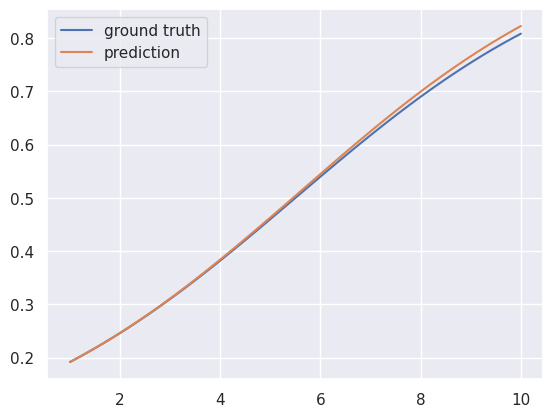

In [38]:
# plot prediction and actual for one sample
from odeformer.metrics import r2_score
sample_name = os.fsdecode('sample_sig_7.pt')
if "sig" in sample_name:
  sample_path = os.path.join(samples_path, sample_name)
  with open(sample_path, 'rb') as f:
      sample = pickle.load(f)
  # print(sample.keys())
  # print(sample['expression'])
  # print(sample['feature_dict'])
  trajectory = sample['trajectory']
  times = sample['times']
  preds = dstr.fit(times, trajectory)
  pred_traj = dstr.predict(times, trajectory[0])
  print('sample:')
  print(sample['expression'])
  print('prediction:')
  dstr.print()
  print('r2 = ', r2_score(sample['trajectory'], pred_traj))
  plt.plot(times, trajectory, label='ground truth')
  plt.plot(times, pred_traj, label='prediction')
  plt.legend()
  plt.show()

## Train probes

In [39]:
import experiments

In [40]:
target_feature = 'derivative_max'
layers = [idx for idx in range(4, 16)]

In [ ]:
# use gradient-based training
probes_path_gradient = f'{probes_path}/gradient'

lr = 0.01
num_epochs = 20
num_repeats = 3

expt_results = experiments.scalar_prediction_experiment(target_feature=target_feature, activations_path=activations_path, \
                     probes_path=probes_path_gradient, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats)
# save experiment results
with open(f'{probes_path_gradient}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)

Repeat 0 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]



Training Set (Epoch 20 - Final): Loss 0.6921955524012446
Regression probe trained on layer 4: Test Set Loss 2.511159700354983
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_4_0.pt
Repeat 1 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]



Training Set (Epoch 20 - Final): Loss 0.25606264602392914
Regression probe trained on layer 4: Test Set Loss 4.184360138205557
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_4_1.pt
Repeat 2 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]



Training Set (Epoch 20 - Final): Loss 0.23315316941589118
Regression probe trained on layer 4: Test Set Loss 3.4070457430228998
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_4_2.pt
Repeat 0 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 0.21935183070600034
Regression probe trained on layer 5: Test Set Loss 8.444337763525255
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_5_0.pt
Repeat 1 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]



Training Set (Epoch 20 - Final): Loss 0.17761389687657356
Regression probe trained on layer 5: Test Set Loss 2.9649696713429874
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_5_1.pt
Repeat 2 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]



Training Set (Epoch 20 - Final): Loss 0.8510576114058495
Regression probe trained on layer 5: Test Set Loss 46.72468543482828
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_5_2.pt
Repeat 0 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.21782102026045322
Regression probe trained on layer 6: Test Set Loss 2.48386519168198
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_6_0.pt
Repeat 1 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]



Training Set (Epoch 20 - Final): Loss 0.2403529543429613
Regression probe trained on layer 6: Test Set Loss 2.3844309672276722
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_6_1.pt
Repeat 2 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]



Training Set (Epoch 20 - Final): Loss 0.47253782004117967
Regression probe trained on layer 6: Test Set Loss 3.902936220831356
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_6_2.pt
Repeat 0 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 0.17829577550292014
Regression probe trained on layer 7: Test Set Loss 3.2362379365818925
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_7_0.pt
Repeat 1 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]



Training Set (Epoch 20 - Final): Loss 0.17855883222073315
Regression probe trained on layer 7: Test Set Loss 2.8806206386136184
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_7_1.pt
Repeat 2 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.18996242713183165
Regression probe trained on layer 7: Test Set Loss 2.653788540656933
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_7_2.pt
Repeat 0 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.14353875089436768
Regression probe trained on layer 8: Test Set Loss 2.6303832971869268
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_8_0.pt
Repeat 1 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.146645705960691
Regression probe trained on layer 8: Test Set Loss 3.0880300588825778
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_8_1.pt
Repeat 2 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]



Training Set (Epoch 20 - Final): Loss 0.15162579920142888
Regression probe trained on layer 8: Test Set Loss 2.158993815024587
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_8_2.pt
Repeat 0 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.15168480668216944
Regression probe trained on layer 9: Test Set Loss 1.8059121427475475
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_9_0.pt
Repeat 1 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.17115400712937118
Regression probe trained on layer 9: Test Set Loss 2.828459019357706
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_9_1.pt
Repeat 2 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]



Training Set (Epoch 20 - Final): Loss 0.1461655561812222
Regression probe trained on layer 9: Test Set Loss 2.181351128222741
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_9_2.pt
Repeat 0 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]



Training Set (Epoch 20 - Final): Loss 0.1981913039460778
Regression probe trained on layer 10: Test Set Loss 1.883759294824813
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_10_0.pt
Repeat 1 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]



Training Set (Epoch 20 - Final): Loss 0.26585290171206
Regression probe trained on layer 10: Test Set Loss 3.7500749592021747
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_10_1.pt
Repeat 2 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.1464942418038845
Regression probe trained on layer 10: Test Set Loss 1.8671592894410423
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_10_2.pt
Repeat 0 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.14448021799325944
Regression probe trained on layer 11: Test Set Loss 2.5089367490575
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_11_0.pt
Repeat 1 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.14956608060747384
Regression probe trained on layer 11: Test Set Loss 1.704903841953319
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_11_1.pt
Repeat 2 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]



Training Set (Epoch 20 - Final): Loss 0.15436496380716563
Regression probe trained on layer 11: Test Set Loss 3.1414797885815915
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_11_2.pt
Repeat 0 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]



Training Set (Epoch 20 - Final): Loss 0.15120227048173546
Regression probe trained on layer 12: Test Set Loss 1.736341722095176
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_12_0.pt
Repeat 1 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.15213176710531115
Regression probe trained on layer 12: Test Set Loss 2.030743804885424
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_12_1.pt
Repeat 2 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]



Training Set (Epoch 20 - Final): Loss 0.20375032294541598
Regression probe trained on layer 12: Test Set Loss 2.3630834749845233
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_12_2.pt
Repeat 0 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.15464711971580983
Regression probe trained on layer 13: Test Set Loss 2.755681571011519
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_13_0.pt
Repeat 1 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.1425831291824579
Regression probe trained on layer 13: Test Set Loss 2.151039507200403
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_13_1.pt
Repeat 2 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]



Training Set (Epoch 20 - Final): Loss 0.14508283454924822
Regression probe trained on layer 13: Test Set Loss 2.7681529633235185
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_13_2.pt
Repeat 0 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.1597571412101388
Regression probe trained on layer 14: Test Set Loss 2.140873967793959
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_14_0.pt
Repeat 1 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.45s/it]



Training Set (Epoch 20 - Final): Loss 0.1615119321271777
Regression probe trained on layer 14: Test Set Loss 3.6328063664026558
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_14_1.pt
Repeat 2 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.1680617030709982
Regression probe trained on layer 14: Test Set Loss 1.8820903650430865
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_14_2.pt
Repeat 0 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]



Training Set (Epoch 20 - Final): Loss 0.20465355571359395
Regression probe trained on layer 15: Test Set Loss 1.9041156459946706
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_15_0.pt
Repeat 1 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.55s/it]



Training Set (Epoch 20 - Final): Loss 0.16410893779247998
Regression probe trained on layer 15: Test Set Loss 1.7545295898162294
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_15_1.pt
Repeat 2 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 0.16427517738193273
Regression probe trained on layer 15: Test Set Loss 2.9728262663265923
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/gradient/probe_derivative_max_15_2.pt


In [ ]:
expt_results

,layer,run,test_loss,final_train_loss,final_val_loss,test_r2,test_spearman,test_pearson
0,4,0,2.511160,0.692196,"(1.3824498451407181, 0.3975081309381353, 0.737...",0.374561,0.753322,0.772660
1,4,1,4.184360,0.256063,"(2.980898656840145, -0.29911922167790883, 0.44...",-0.042173,0.274129,0.294354
2,4,2,3.407046,0.233153,"(3.1255867428735655, -0.3621764270777934, 0.48...",0.151428,0.481337,0.484388
3,5,0,8.444338,0.219352,"(8.929789492994678, -2.8917328349572102, 0.683...",-1.103179,0.724559,0.600915
4,5,1,2.964970,0.177614,"(1.4608149088522169, 0.36335549828352975, 0.72...",0.261533,0.771498,0.776742
5,5,2,46.724685,0.851058,"(29.116841103884873, -11.689545765034891, 0.40...",-10.637427,0.270905,-0.223566
6,6,0,2.483865,0.217821,"(1.3631958695547042, 0.4058993064452747, 0.705...",0.381359,0.688804,0.662769
7,6,1,2.384431,0.240353,"(1.73760402421467, 0.2427267365286061, 0.70478...",0.406125,0.676356,0.655733
8,6,2,3.902936,0.472538,"(1.7925536713486963, 0.2187788887714538, 0.645...",0.027920,0.548148,0.535048
9,7,0,3.236238,0.178296,"(1.7663075280559497, 0.23021733404715938, 0.58...",0.193970,0.697443,0.642516


In [ ]:
# use direct solver
probes_path_solver = f'{probes_path}/solver'

expt_results = experiments.scalar_prediction_experiment_w_solver(target_feature=target_feature, activations_path=activations_path, \
                     probes_path=probes_path_solver, \
                     layers=layers)

# save experiment results
with open(f'{probes_path_solver}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)


Training on each layer:   0%|          | 0/12 [00:00<?, ?it/s]

Regression probe trained on layer 4: Test Set Loss 2.070553590712598



Training on each layer:   8%|▊         | 1/12 [00:40<07:26, 40.59s/it]

Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_4_0.pt



Training on each layer:  17%|█▋        | 2/12 [00:50<03:43, 22.40s/it]

Regression probe trained on layer 5: Test Set Loss 2.0599533810513093
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_5_0.pt



Training on each layer:  25%|██▌       | 3/12 [01:00<02:32, 16.90s/it]

Regression probe trained on layer 6: Test Set Loss 1.9502736215205458
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_6_0.pt



Training on each layer:  33%|███▎      | 4/12 [01:11<01:54, 14.34s/it]

Regression probe trained on layer 7: Test Set Loss 1.863735217140129
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_7_0.pt


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.85338e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T

Training on each layer:  42%|████▏     | 5/12 [01:21<01:30, 12.90s/it]

Regression probe trained on layer 8: Test Set Loss 2.0779642416076967
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_8_0.pt


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.03416e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T

Training on each layer:  50%|█████     | 6/12 [01:31<01:11, 11.93s/it]

Regression probe trained on layer 9: Test Set Loss 2.1530378879073395
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_9_0.pt



Training on each layer:  58%|█████▊    | 7/12 [01:41<00:56, 11.26s/it]

Regression probe trained on layer 10: Test Set Loss 2.59923897634435
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_10_0.pt


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.64533e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T

Training on each layer:  67%|██████▋   | 8/12 [01:51<00:43, 10.87s/it]

Regression probe trained on layer 11: Test Set Loss 2.499348704353906
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_11_0.pt



Training on each layer:  75%|███████▌  | 9/12 [02:01<00:31, 10.57s/it]

Regression probe trained on layer 12: Test Set Loss 2.7265849459130984
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_12_0.pt



Training on each layer:  83%|████████▎ | 10/12 [02:11<00:20, 10.33s/it]

Regression probe trained on layer 13: Test Set Loss 2.81718373199451
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_13_0.pt



Training on each layer:  92%|█████████▏| 11/12 [02:22<00:10, 10.75s/it]

Regression probe trained on layer 14: Test Set Loss 2.461202100562514
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_14_0.pt



Training on each layer: 100%|██████████| 12/12 [02:34<00:00, 12.86s/it]

Regression probe trained on layer 15: Test Set Loss 2.4180118993287123
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid/solver/probe_derivative_max_15_0.pt


In [ ]:
expt_results

,layer,test_loss,final_train_loss,final_val_loss,test_r2,test_spearman,test_pearson
0,4,2.070554,1.802736,1.548264,0.484300,0.747856,0.711420
1,5,2.059953,1.856870,1.350292,0.486940,0.743156,0.714729
2,6,1.950274,1.938577,1.266495,0.514257,0.772237,0.745778
3,7,1.863735,1.951678,1.240188,0.535811,0.770936,0.765229
4,8,2.077964,1.814333,1.332701,0.482454,0.752170,0.707914
5,9,2.153038,1.671466,1.396169,0.463756,0.745981,0.697813
6,10,2.599239,1.391933,2.181533,0.352624,0.657204,0.616503
7,11,2.499349,1.476385,1.703024,0.377503,0.722644,0.632215
8,12,2.726585,1.344604,1.806163,0.320906,0.658188,0.595359
9,13,2.817184,1.369039,1.618140,0.298342,0.644111,0.582841


In [41]:
# for wider range of timepoints
# use direct solver
probes_path_solver = f'{probes_path}'

expt_results = experiments.scalar_prediction_experiment_w_solver(target_feature=target_feature, activations_path=activations_path, \
                     probes_path=probes_path, \
                     layers=layers)

# save experiment results
with open(f'{probes_path}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)


Training on each layer:   8%|▊         | 1/12 [00:13<02:30, 13.72s/it]

Regression probe trained on layer 4: Test Set Loss 1.95411939822734
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_4_0.pt



Training on each layer:  17%|█▋        | 2/12 [00:26<02:14, 13.44s/it]

Regression probe trained on layer 5: Test Set Loss 2.6236582387480665
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_5_0.pt



Training on each layer:  25%|██▌       | 3/12 [00:40<02:01, 13.47s/it]

Regression probe trained on layer 6: Test Set Loss 1.8993689633195117
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_6_0.pt



Training on each layer:  33%|███▎      | 4/12 [01:01<02:11, 16.50s/it]

Regression probe trained on layer 7: Test Set Loss 1.9074392696173164
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_7_0.pt



Training on each layer:  42%|████▏     | 5/12 [01:14<01:47, 15.36s/it]

Regression probe trained on layer 8: Test Set Loss 1.792025904369075
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_8_0.pt



Training on each layer:  50%|█████     | 6/12 [01:28<01:28, 14.67s/it]

Regression probe trained on layer 9: Test Set Loss 2.033677688815078
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_9_0.pt



Training on each layer:  58%|█████▊    | 7/12 [01:41<01:10, 14.17s/it]

Regression probe trained on layer 10: Test Set Loss 2.5773290785546124
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_10_0.pt



Training on each layer:  67%|██████▋   | 8/12 [01:55<00:56, 14.15s/it]

Regression probe trained on layer 11: Test Set Loss 1.7012433513758878
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_11_0.pt



Training on each layer:  75%|███████▌  | 9/12 [02:08<00:41, 13.73s/it]

Regression probe trained on layer 12: Test Set Loss 3.1908488128563475
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_12_0.pt



Training on each layer:  83%|████████▎ | 10/12 [02:21<00:27, 13.53s/it]

Regression probe trained on layer 13: Test Set Loss 2.390646397929231
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_13_0.pt



Training on each layer:  92%|█████████▏| 11/12 [02:34<00:13, 13.41s/it]

Regression probe trained on layer 14: Test Set Loss 2.200832623183851
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_14_0.pt



Training on each layer: 100%|██████████| 12/12 [02:47<00:00, 13.98s/it]

Regression probe trained on layer 15: Test Set Loss 1.818190462383609
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/sigmoid2/probe_derivative_max_15_0.pt


## Plot results

In [5]:
import experiments.utils as expt_utils

### results with solver

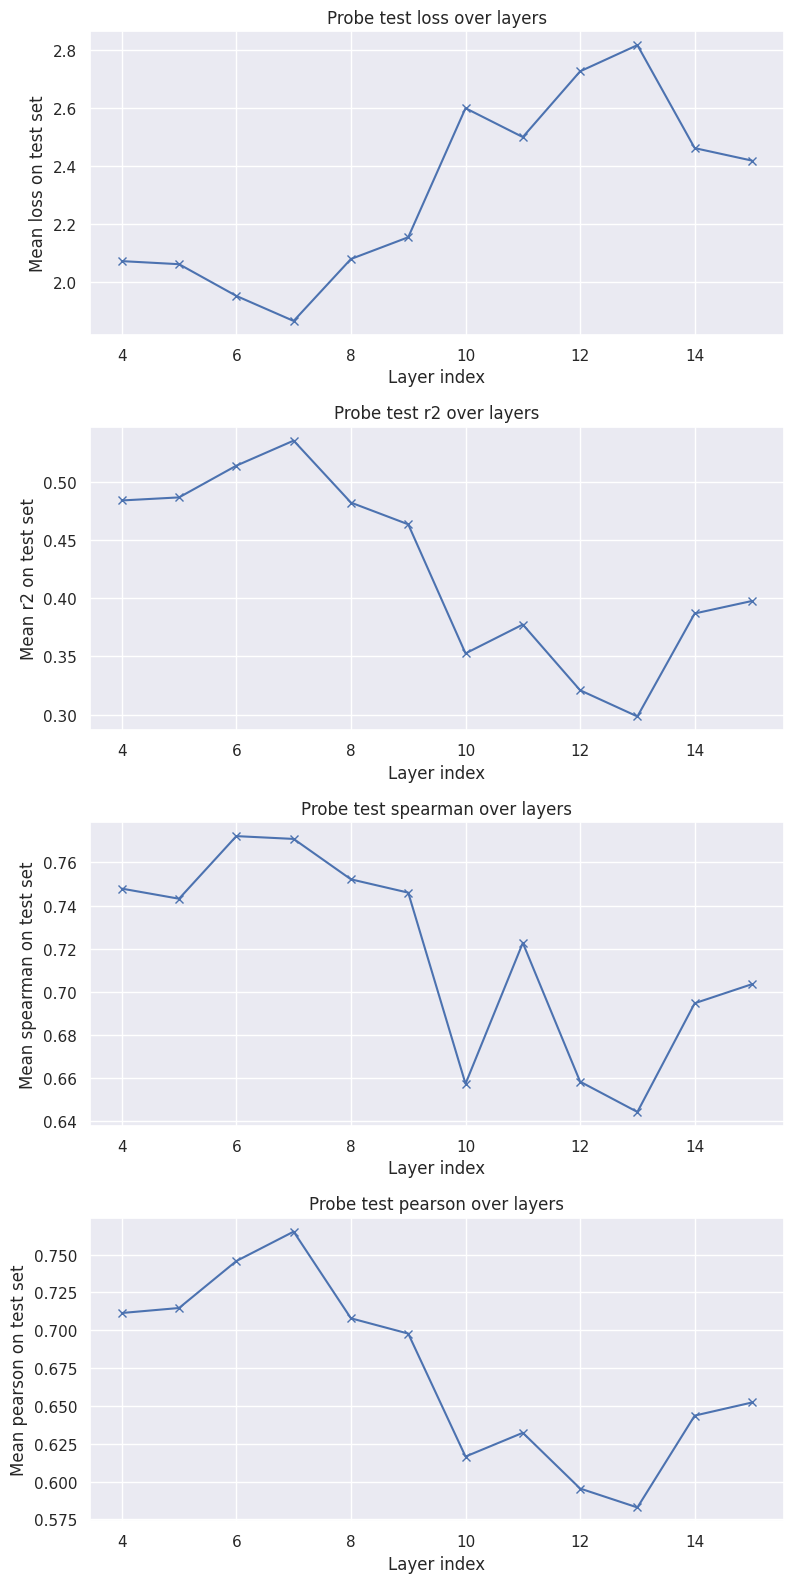

In [ ]:
# load expt results
with open(f'{probes_path_solver}/experiment_data.pt', 'rb') as f:
    expt_results = pickle.load(f)
expt_summary = expt_utils.summarise_experiment(expt_results, incl_extras = True)

# plot decoder layers
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_max', layers = range(4,16))

In [ ]:
expt_summary

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,4,0.484300,NaN,0.747856,NaN,0.711420,NaN,2.070554,NaN
1,5,0.486940,NaN,0.743156,NaN,0.714729,NaN,2.059953,NaN
2,6,0.514257,NaN,0.772237,NaN,0.745778,NaN,1.950274,NaN
3,7,0.535811,NaN,0.770936,NaN,0.765229,NaN,1.863735,NaN
4,8,0.482454,NaN,0.752170,NaN,0.707914,NaN,2.077964,NaN
5,9,0.463756,NaN,0.745981,NaN,0.697813,NaN,2.153038,NaN
6,10,0.352624,NaN,0.657204,NaN,0.616503,NaN,2.599239,NaN
7,11,0.377503,NaN,0.722644,NaN,0.632215,NaN,2.499349,NaN
8,12,0.320906,NaN,0.658188,NaN,0.595359,NaN,2.726585,NaN
9,13,0.298342,NaN,0.644111,NaN,0.582841,NaN,2.817184,NaN


Repeat 0 of layer 4


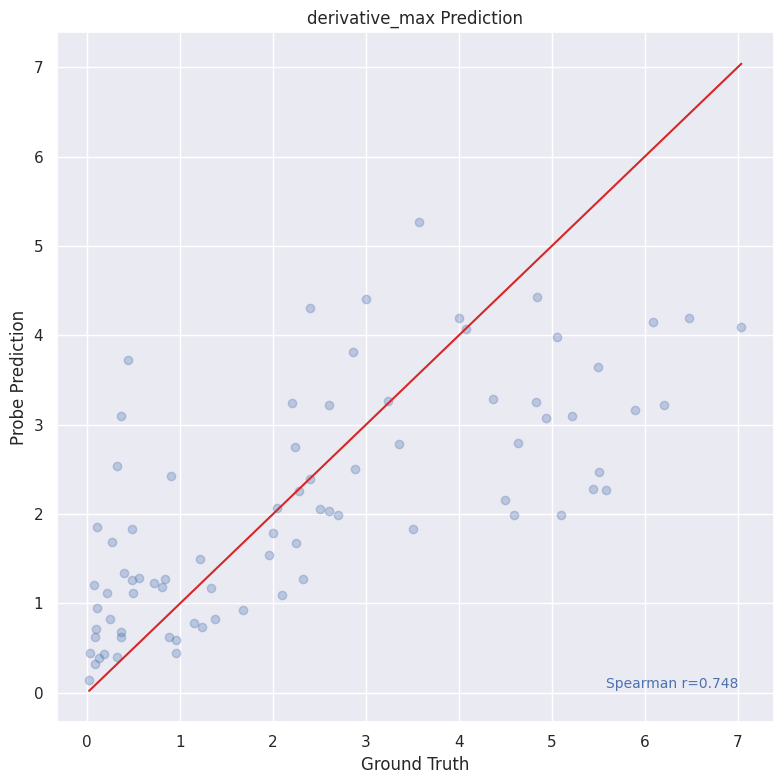

Repeat 0 of layer 5


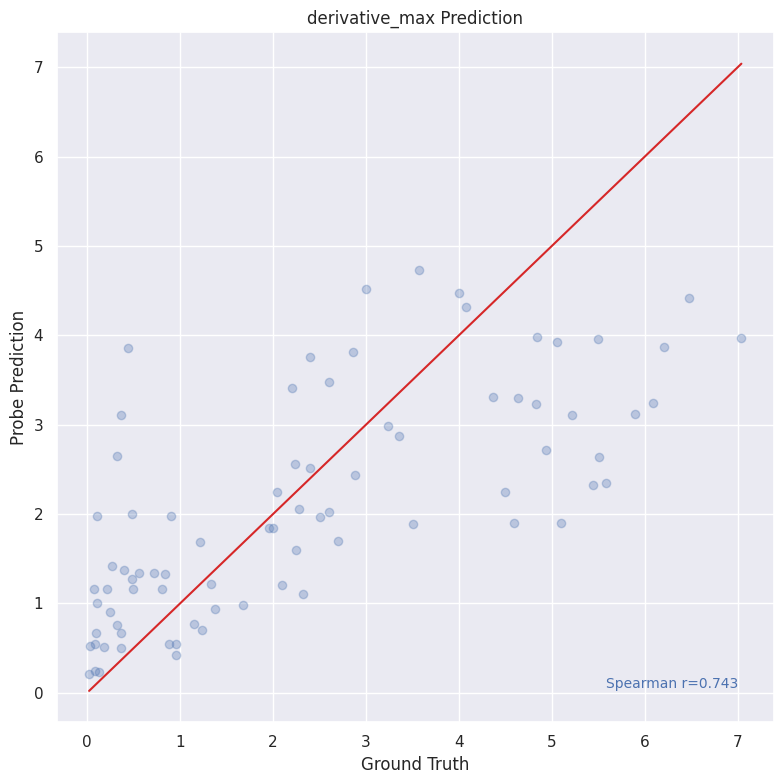

Repeat 0 of layer 6


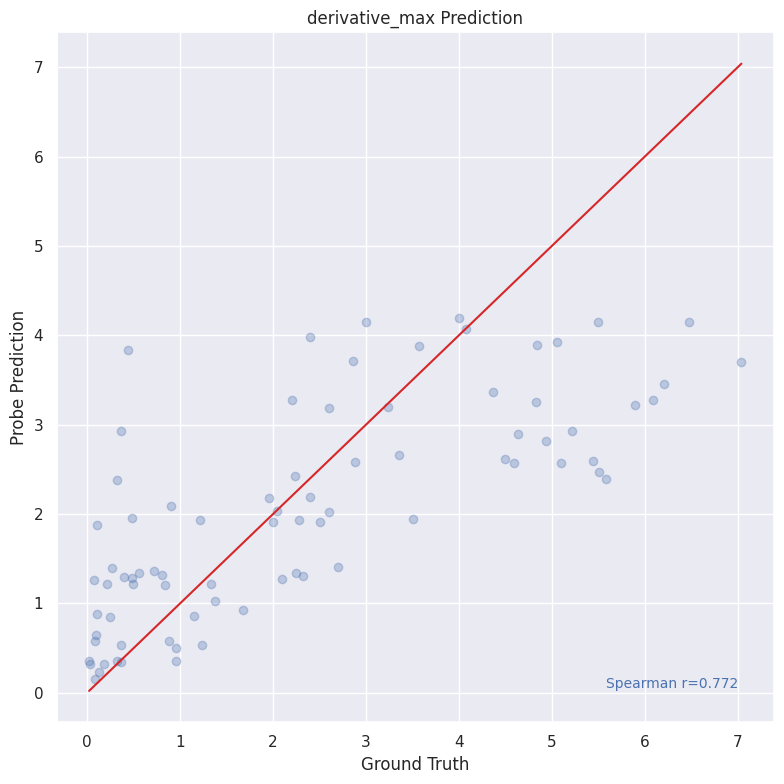

Repeat 0 of layer 7


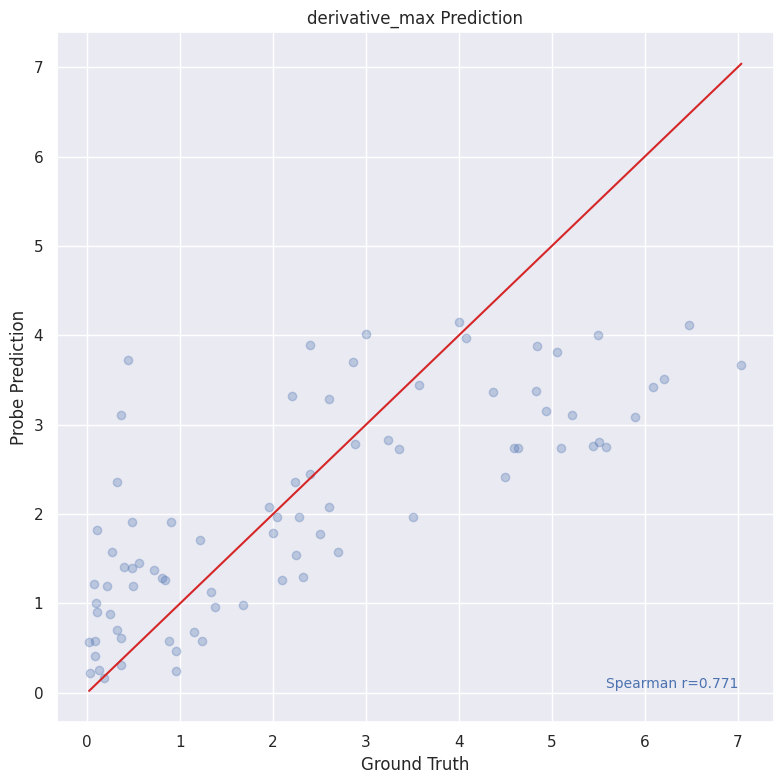

Repeat 0 of layer 8


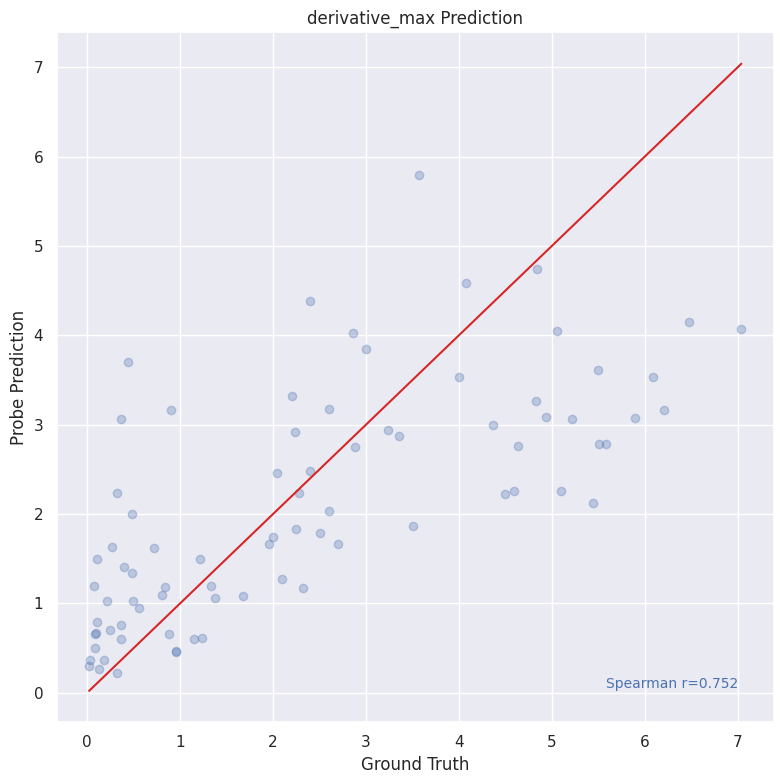

Repeat 0 of layer 9


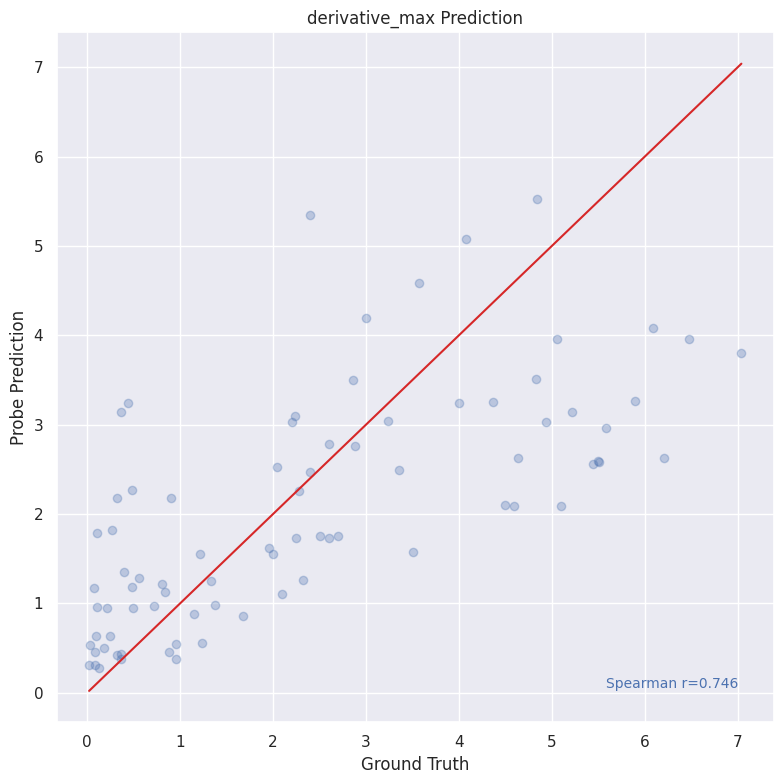

Repeat 0 of layer 10


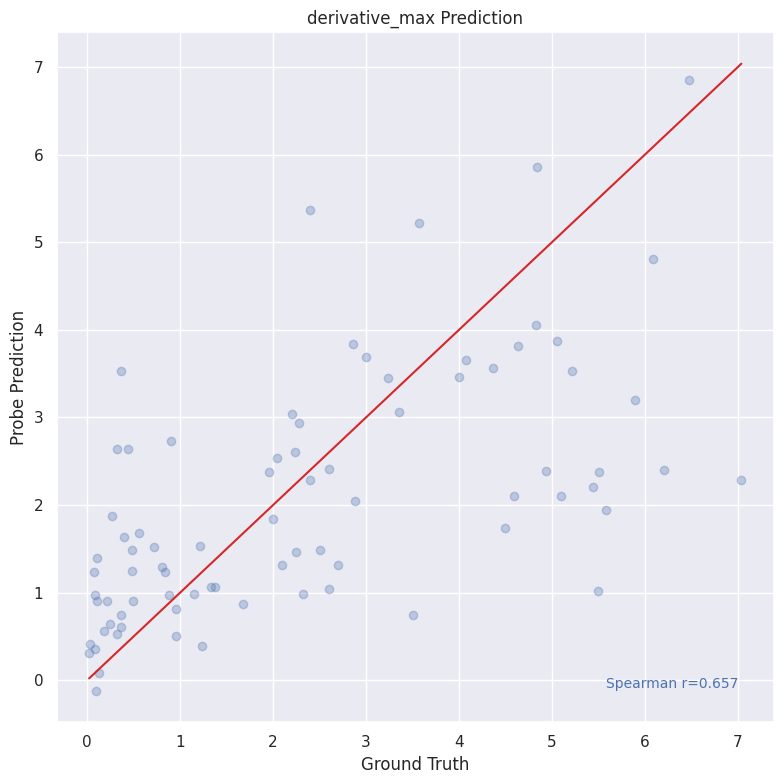

Repeat 0 of layer 11


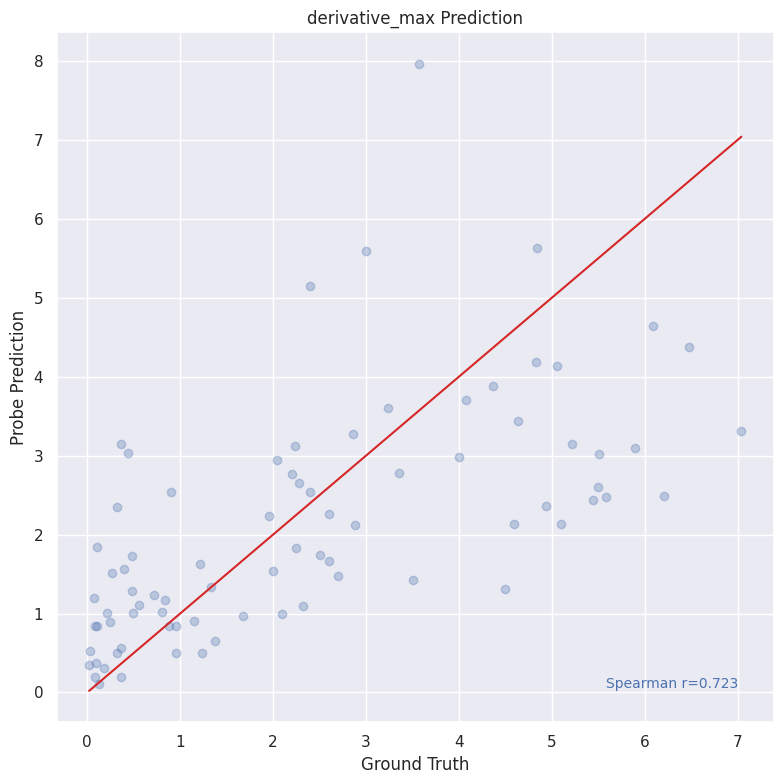

Repeat 0 of layer 12


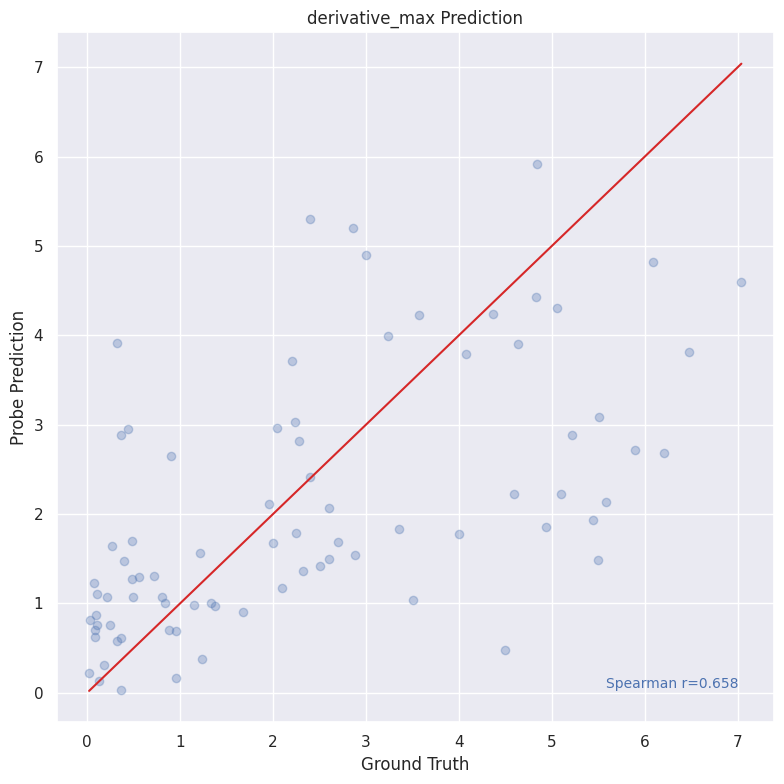

Repeat 0 of layer 13


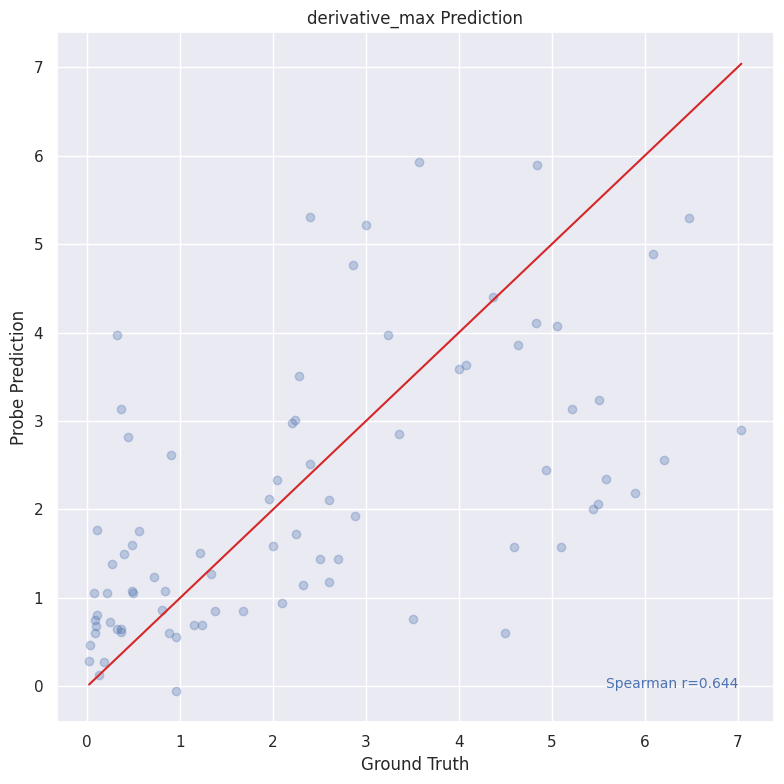

Repeat 0 of layer 14


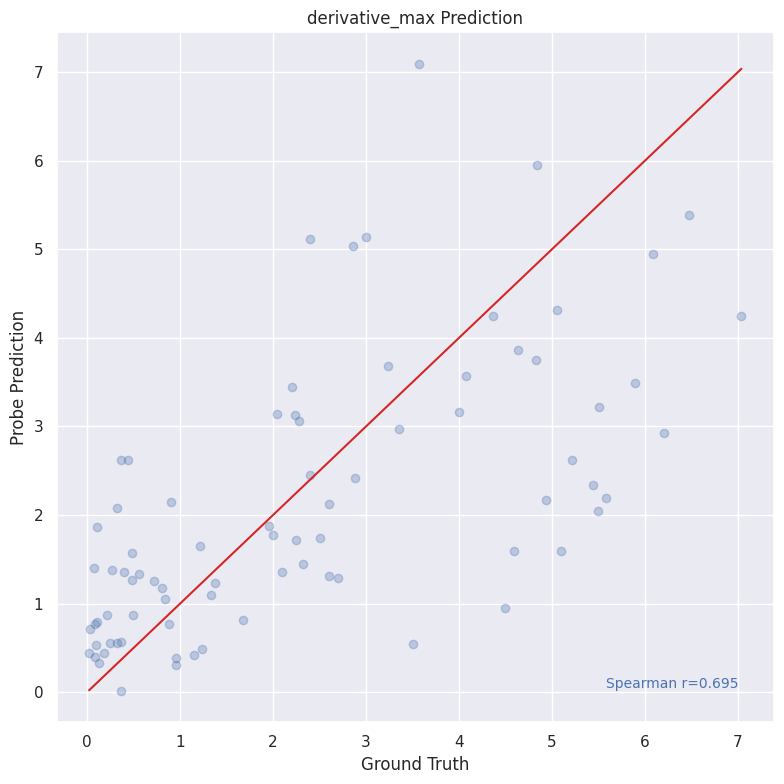

Repeat 0 of layer 15


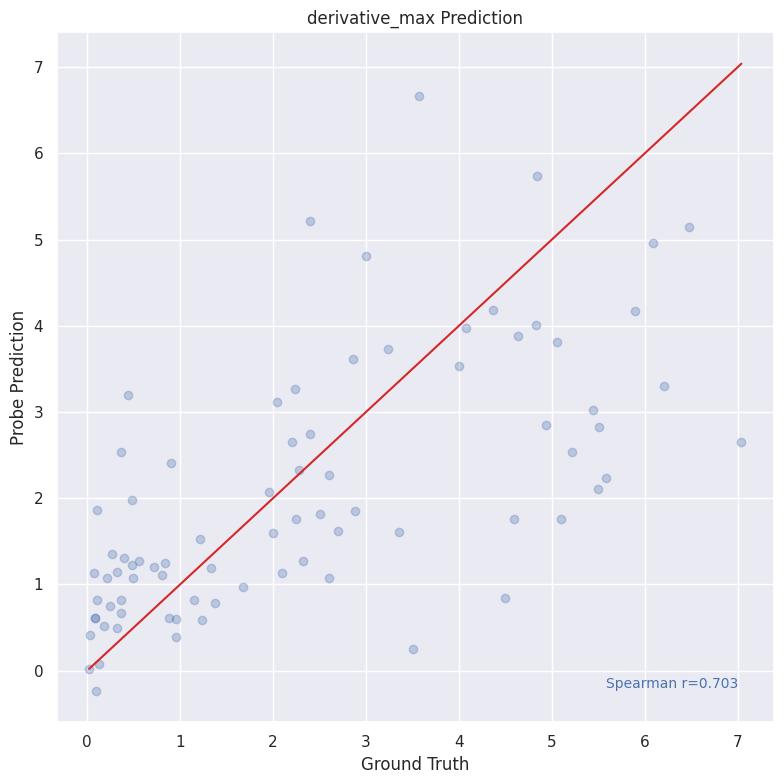

In [ ]:
# plot prediction vs ground truth for derivative_max

layers = range(4,16)

target_feature = 'derivative_max'
feature_descriptor = 'derivative_max'
descriptor = ' '

expt_utils.plot_all_scalar_predictions(target_feature, feature_descriptor, descriptor, activations_path, probes_path_solver, layers)

### using gradient-based method

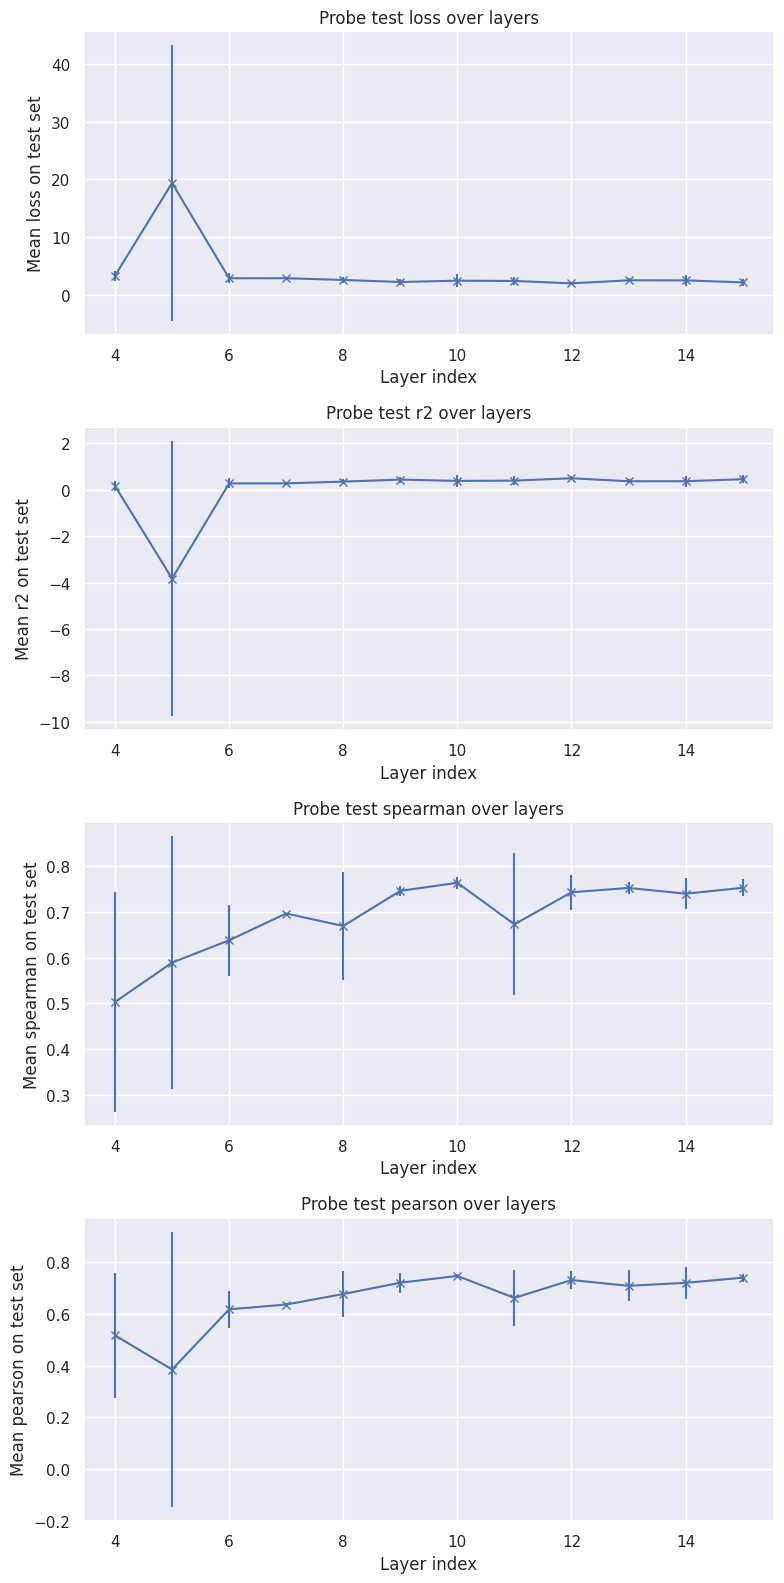

In [ ]:
# load expt results
with open(f'{probes_path_gradient}/experiment_data.pt', 'rb') as f:
    expt_results = pickle.load(f)
expt_summary = expt_utils.summarise_experiment(expt_results, incl_extras = True)

# plot decoder layers
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_max', layers = range(4,16))

In [ ]:
expt_summary

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,4,0.161272,0.208541,0.502929,0.240325,0.517134,0.240829,3.367522,0.837300
1,5,-3.826357,5.937896,0.588987,0.276465,0.384697,0.534057,19.377998,23.840866
2,6,0.271801,0.211570,0.637770,0.077864,0.617850,0.071795,2.923744,0.849461
3,7,0.271850,0.073122,0.696336,0.001383,0.636474,0.005644,2.923549,0.293588
4,8,0.346008,0.115699,0.669032,0.116975,0.677126,0.087453,2.625802,0.464535
5,9,0.434150,0.128829,0.745797,0.010829,0.720906,0.038524,2.271907,0.517253
6,10,0.377258,0.269572,0.763514,0.012714,0.747182,0.008539,2.500331,1.082342
7,11,0.389352,0.179324,0.672629,0.155129,0.662092,0.107524,2.451773,0.719992
8,12,0.491066,0.078097,0.742706,0.038148,0.731254,0.033807,2.043390,0.313562
9,13,0.362822,0.087856,0.752248,0.013411,0.708922,0.060292,2.558291,0.352746


Repeat 0 of layer 4
Repeat 1 of layer 4
Repeat 2 of layer 4


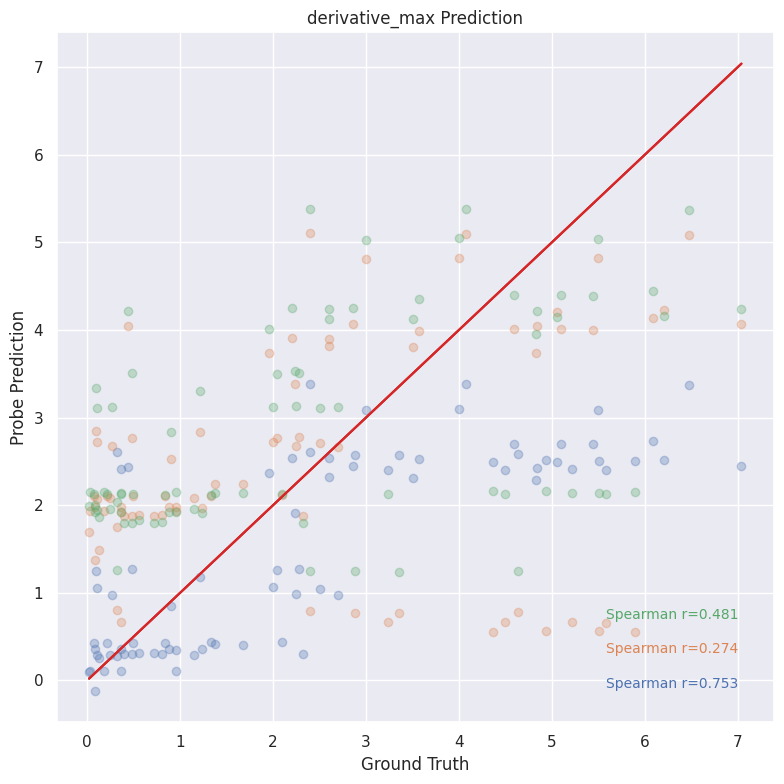

Repeat 0 of layer 5
Repeat 1 of layer 5
Repeat 2 of layer 5


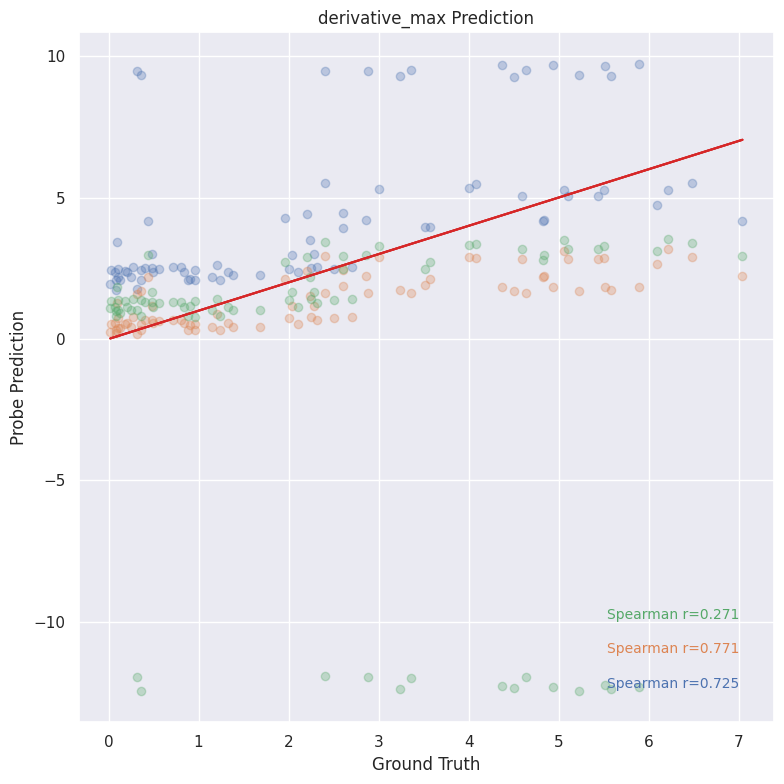

Repeat 0 of layer 6
Repeat 1 of layer 6
Repeat 2 of layer 6


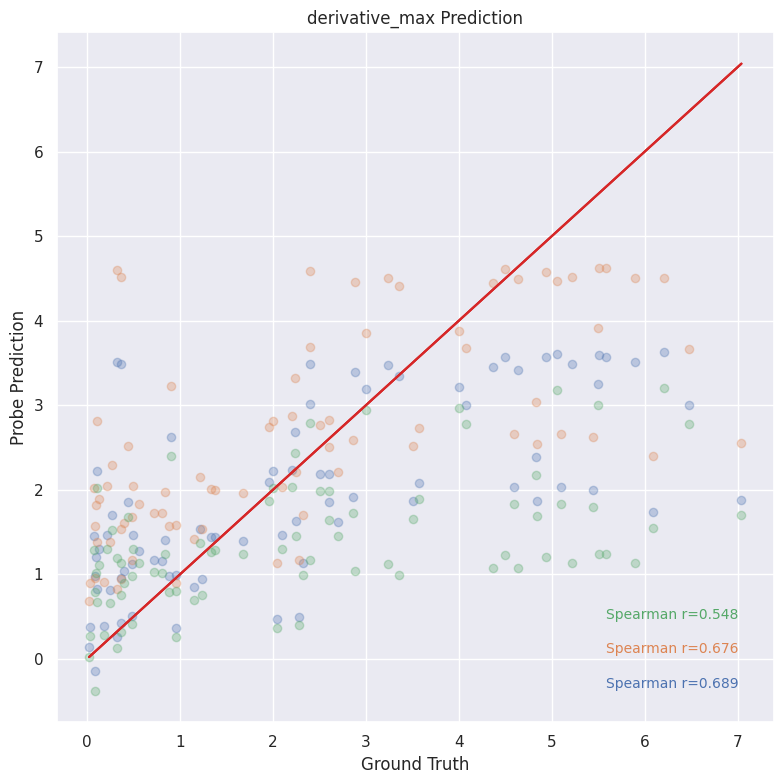

Repeat 0 of layer 7
Repeat 1 of layer 7
Repeat 2 of layer 7


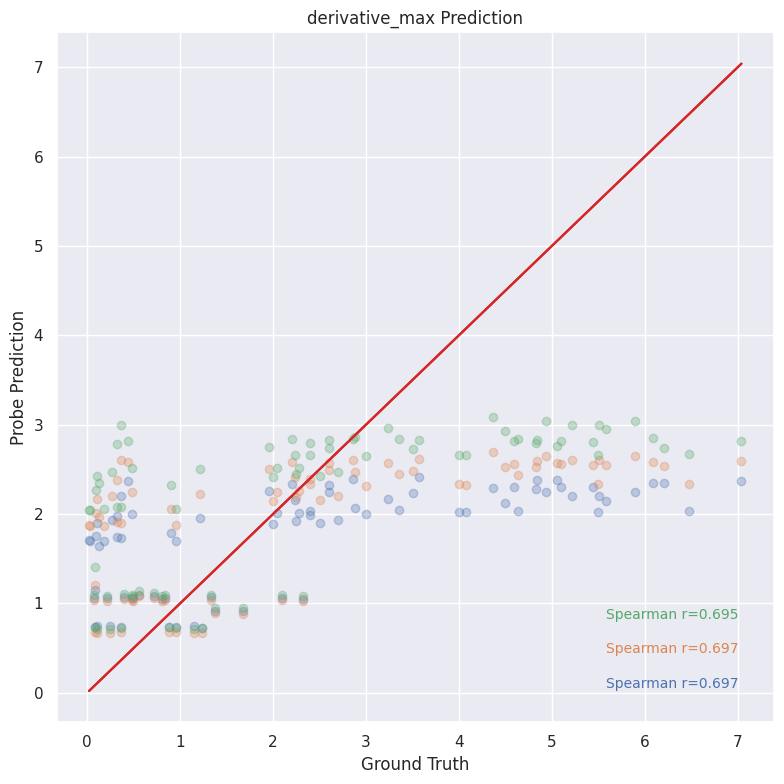

Repeat 0 of layer 8
Repeat 1 of layer 8
Repeat 2 of layer 8


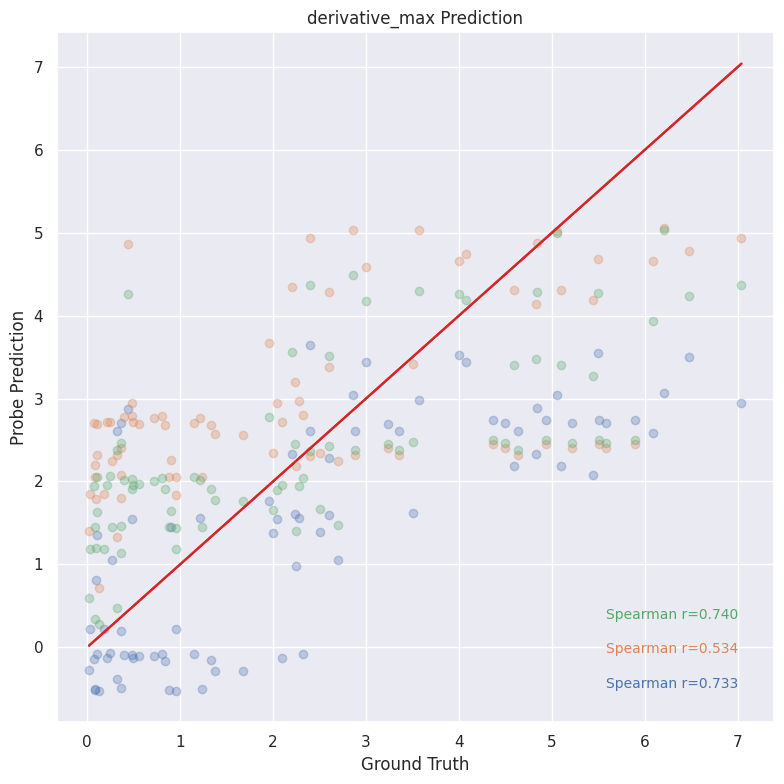

Repeat 0 of layer 9
Repeat 1 of layer 9
Repeat 2 of layer 9


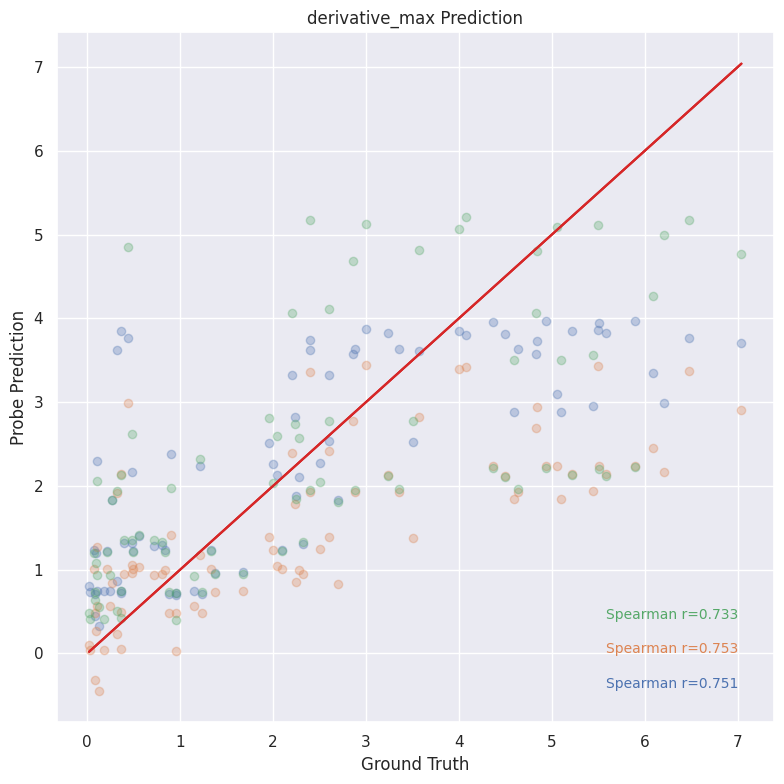

Repeat 0 of layer 10
Repeat 1 of layer 10
Repeat 2 of layer 10


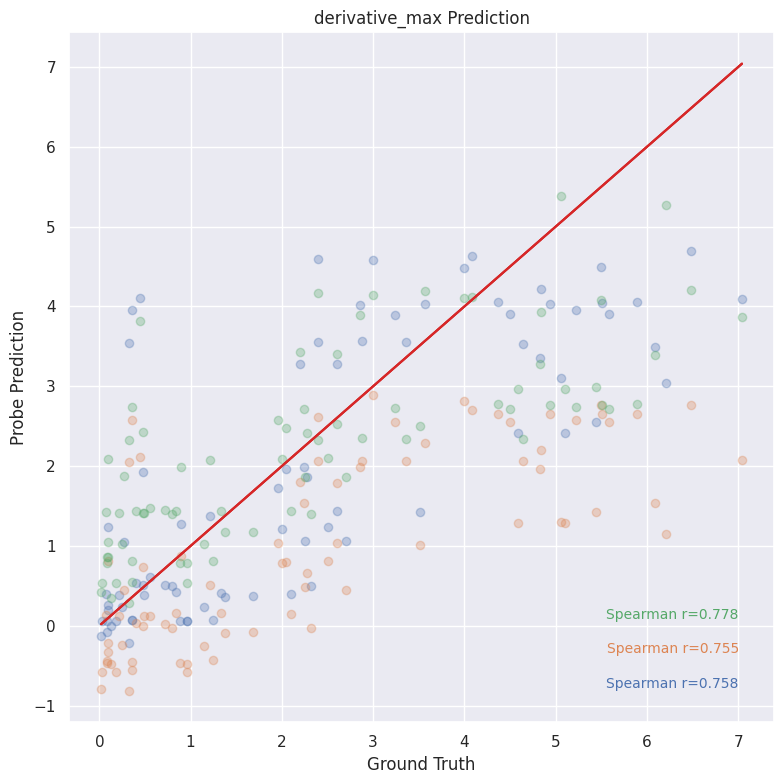

Repeat 0 of layer 11
Repeat 1 of layer 11
Repeat 2 of layer 11


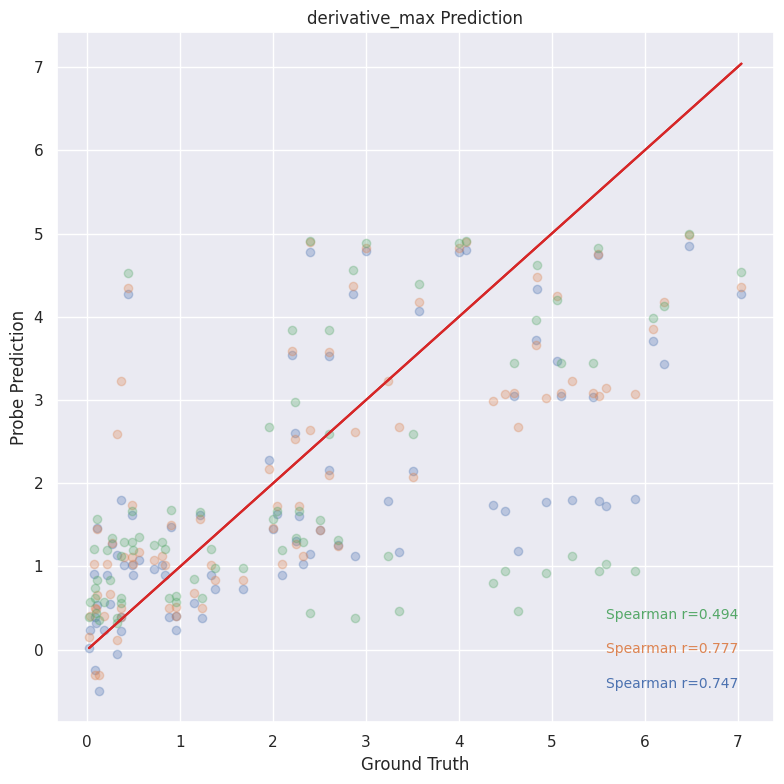

Repeat 0 of layer 12
Repeat 1 of layer 12
Repeat 2 of layer 12


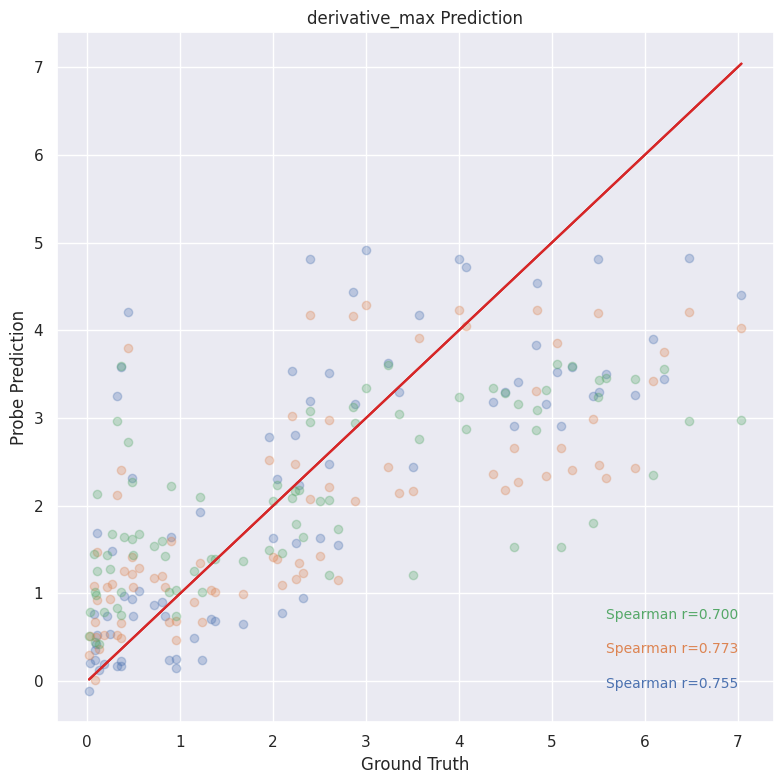

Repeat 0 of layer 13
Repeat 1 of layer 13
Repeat 2 of layer 13


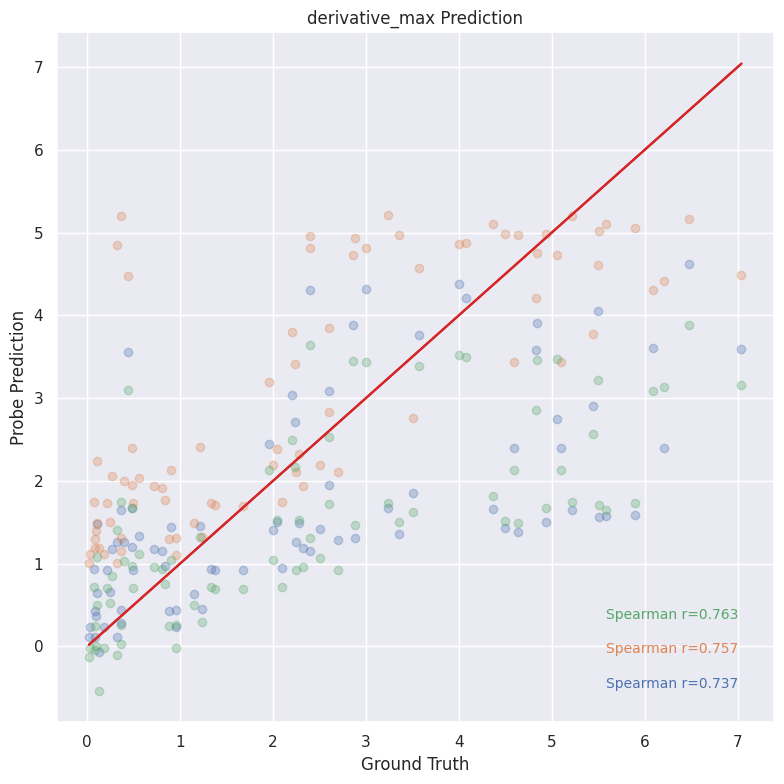

Repeat 0 of layer 14
Repeat 1 of layer 14
Repeat 2 of layer 14


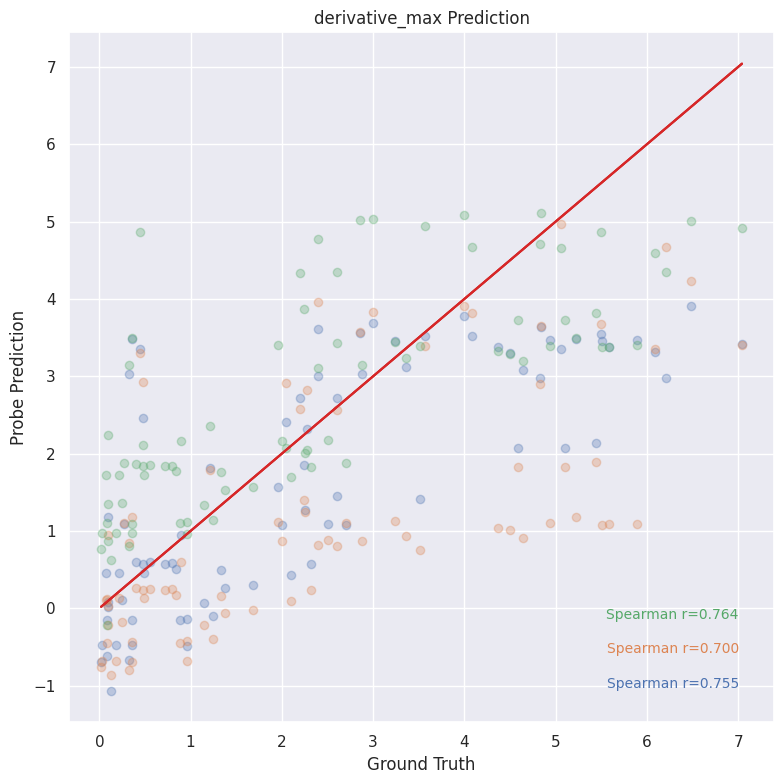

Repeat 0 of layer 15
Repeat 1 of layer 15
Repeat 2 of layer 15


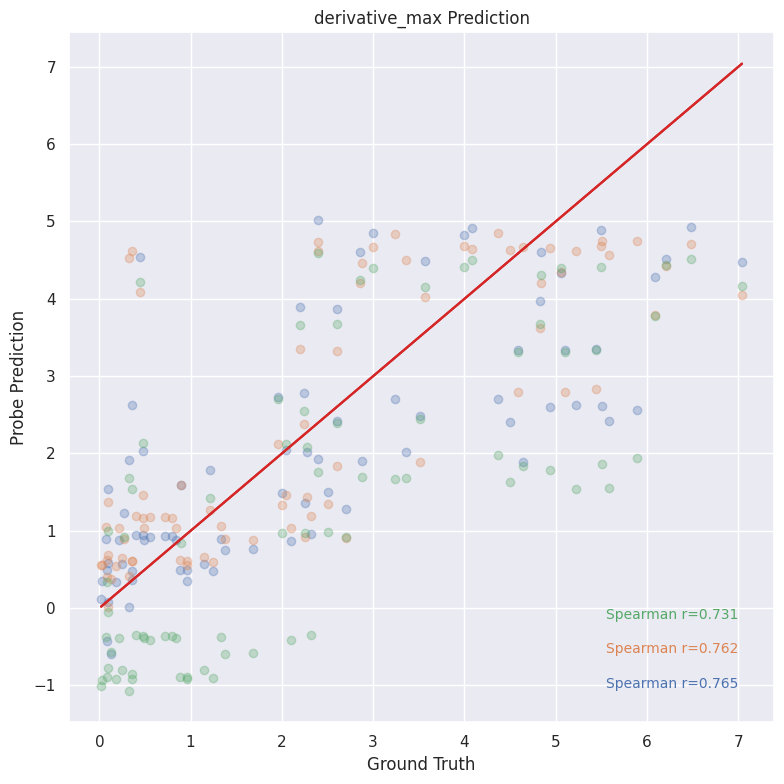

In [ ]:
# plot prediction vs ground truth for derivative_max

layers = range(4,16)

target_feature = 'derivative_max'
feature_descriptor = 'derivative_max'
descriptor = ' '
repeats = 3

expt_utils.plot_all_scalar_predictions(target_feature, feature_descriptor, descriptor, activations_path, probes_path_gradient, layers, num_repeats=repeats)

### Solver with wider range of timepoints

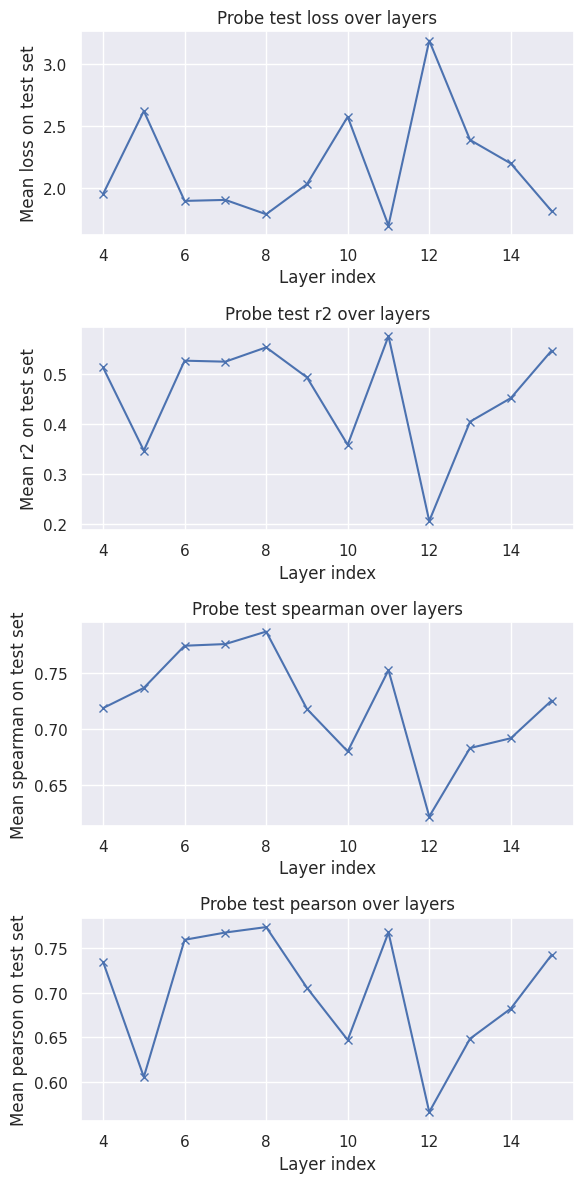

In [6]:
# load expt results
with open(f'{probes_path}/experiment_data.pt', 'rb') as f:
    expt_results = pickle.load(f)
expt_summary = expt_utils.summarise_experiment(expt_results, incl_extras = True)

# plot decoder layers
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_max', layers = range(4,16))

In [8]:
expt_results

,layer,test_loss,final_train_loss,final_val_loss,test_r2,test_spearman,test_pearson
0,4,1.954119,1.701424,1.661318,0.513300,0.718694,0.734549
1,5,2.623658,1.817349,1.604773,0.346542,0.736663,0.605485
2,6,1.899369,1.935521,1.355350,0.526936,0.774171,0.759244
3,7,1.907439,1.945152,1.249871,0.524926,0.775659,0.767394
4,8,1.792026,1.821409,1.675760,0.553671,0.786760,0.773502
5,9,2.033678,1.591087,2.068747,0.493485,0.717967,0.705507
6,10,2.577329,1.191263,2.483286,0.358081,0.680189,0.646988
7,11,1.701243,1.268977,2.077019,0.576282,0.752463,0.767498
8,12,3.190849,1.092542,2.149278,0.205275,0.622298,0.566232
9,13,2.390646,1.193275,2.203950,0.404577,0.683166,0.648402


Repeat 0 of layer 4


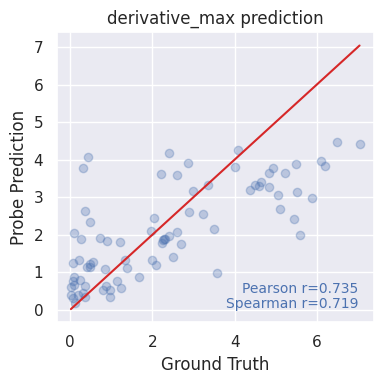

Repeat 0 of layer 5


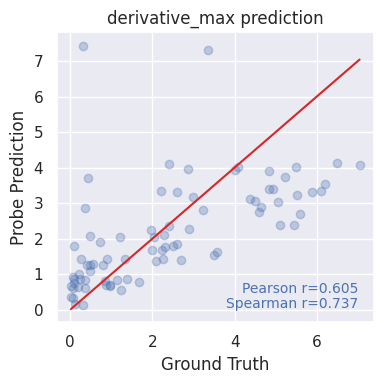

Repeat 0 of layer 6


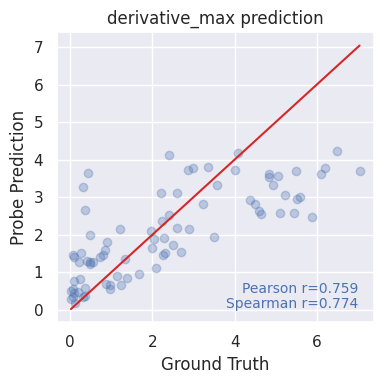

Repeat 0 of layer 7


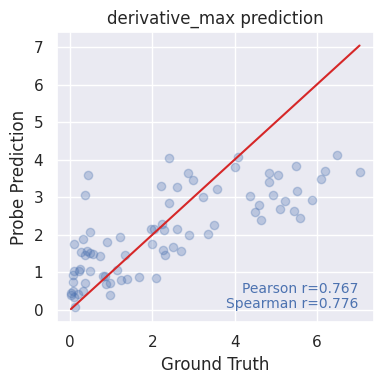

Repeat 0 of layer 8


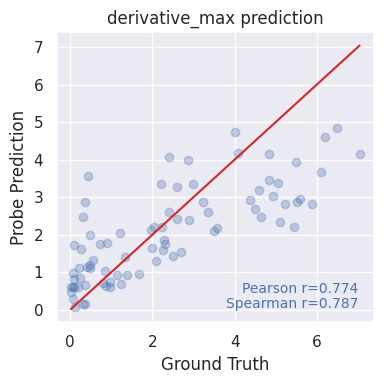

Repeat 0 of layer 9


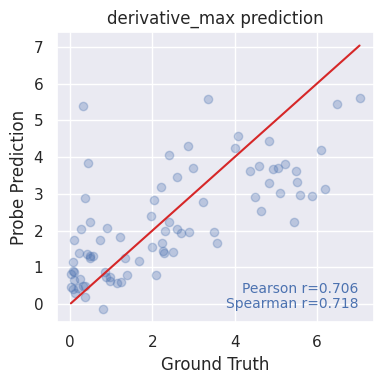

Repeat 0 of layer 10


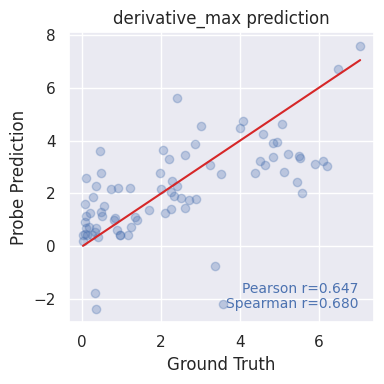

Repeat 0 of layer 11


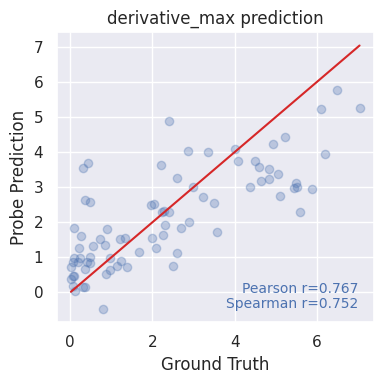

Repeat 0 of layer 12


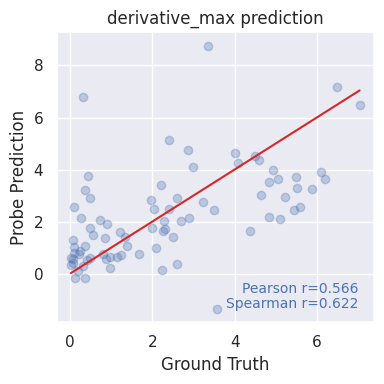

Repeat 0 of layer 13


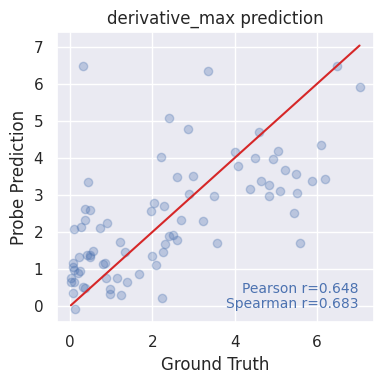

Repeat 0 of layer 14


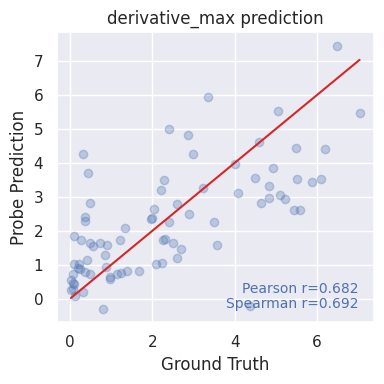

Repeat 0 of layer 15


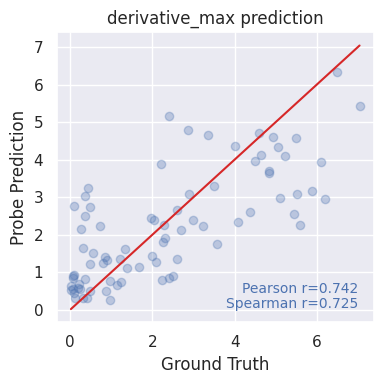

In [7]:
# plot prediction vs ground truth for derivative_max

layers = range(4,16)

target_feature = 'derivative_max'
feature_descriptor = 'derivative_max'
descriptor = ' '

expt_utils.plot_all_scalar_predictions(target_feature, feature_descriptor, descriptor, activations_path, probes_path, layers)